In [33]:
#code of Interactive Quantum Classifier Inspired by Quantum Open System Theory
#LINK https://ieeexplore.ieee.org/document/9533917

#LINK https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9533917

#this code was written by Fernando Maciano de Paula Neto (fernando@cin.ufpe.br) together with Eduardo Barreto Brito (ebb2@cin.ufpe.br)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
from helpers.icq_methods import create_and_execute_classifier

In [35]:
VARY_INPUT = "input"
VARY_BOTH = "both"
DIFFERENT_VARIATIONS = [VARY_INPUT, VARY_BOTH]
MIN_RANGE = 1
MAX_RANGE = 2.0

In [36]:
def generate_many_points(n_points, scale=1, dimensions = 1, varied_part=VARY_INPUT, output_func=create_and_execute_classifier):
  np.random.seed(1000)
  list_of_x = []
  list_of_y = []
  list_of_z = []
  
  for i in range(n_points):
    # We need to study what happens when we variate different things
    if varied_part == VARY_INPUT:
      i_n = scale*np.random.uniform(low=-1, high=1, size=(dimensions,))
      w_n = np.ones((dimensions,))
    elif varied_part == VARY_BOTH:
      i_n = scale*np.random.uniform(low=-1, high=1, size=(dimensions,))
      w_n = scale*np.random.uniform(low=-1, high=1, size=(dimensions,))
    
    z,p_cog = output_func(i_n, w_n)
    list_of_x.append(i_n[0]*w_n[0])
    list_of_y.append(p_cog.real)
    list_of_z.append(z)

  return list_of_x, list_of_y, list_of_z

In [37]:
def plot_graph(list_of_x, list_of_y):
    plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
    ax = plt.gca()
    ax.tick_params(axis='y', colors='red')
    ax.tick_params(axis='x', colors='red')
    
    ax.set_xlabel("i[0] x w[0]")
    ax.xaxis.label.set_color('red')

    ax.set_ylabel("p0")
    ax.yaxis.label.set_color('red')
    
    plt.xticks(np.arange(MAX_RANGE * (-1), MAX_RANGE, 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.show()

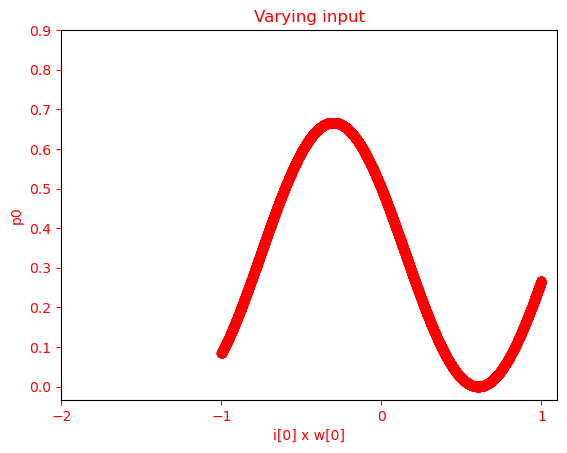

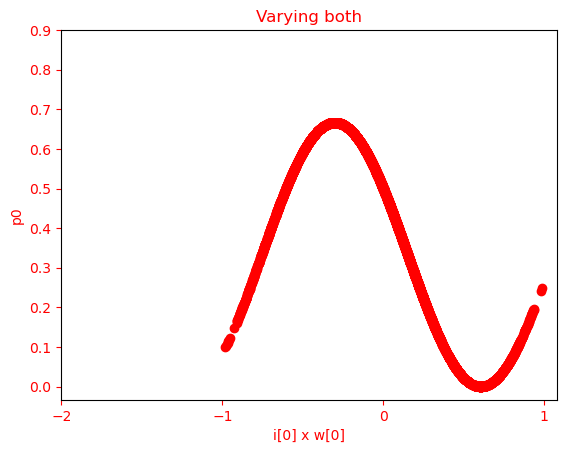

Wall time: 3.84 s


In [38]:
%%time
# First let's see only what happens when we change what we're trying to vary
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(10000, varied_part=variation)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

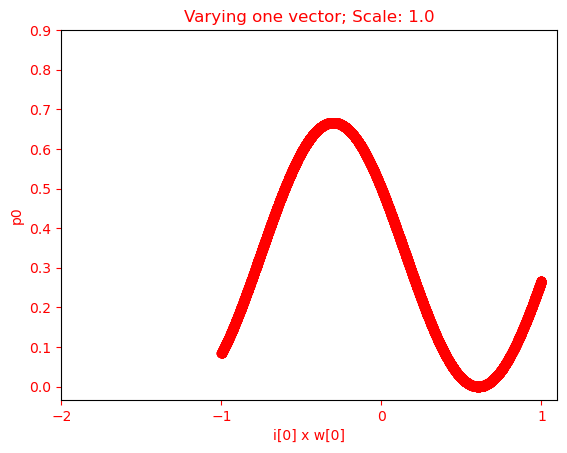

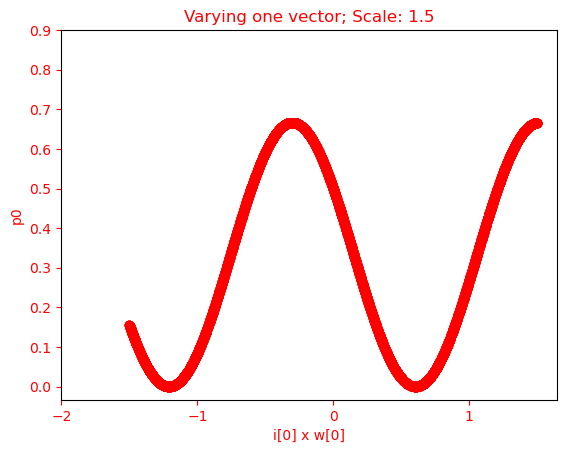

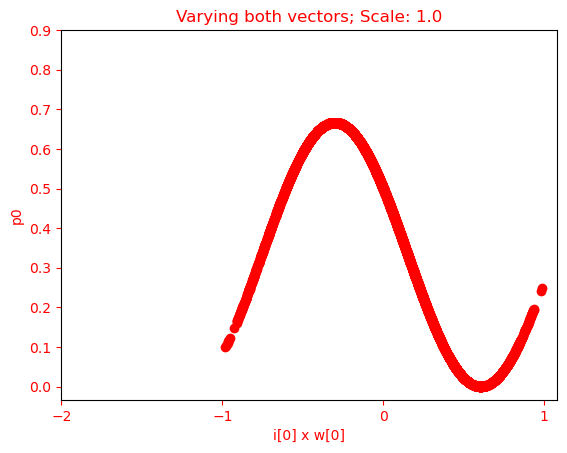

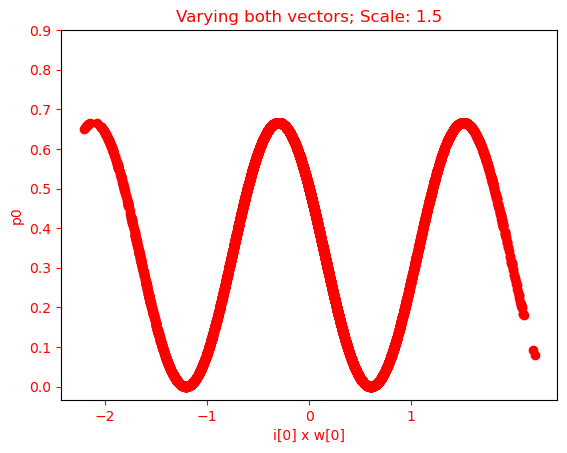

Wall time: 7.63 s


In [39]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)

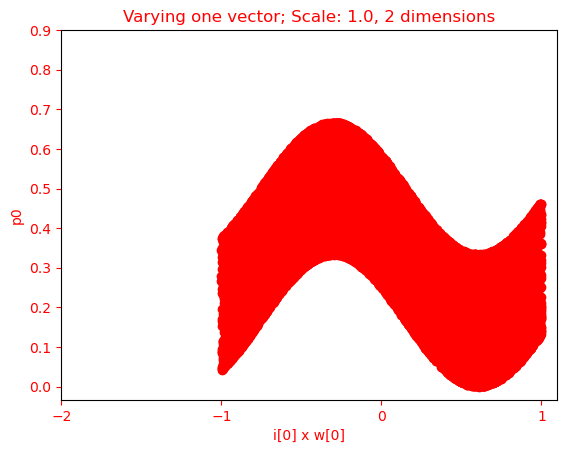

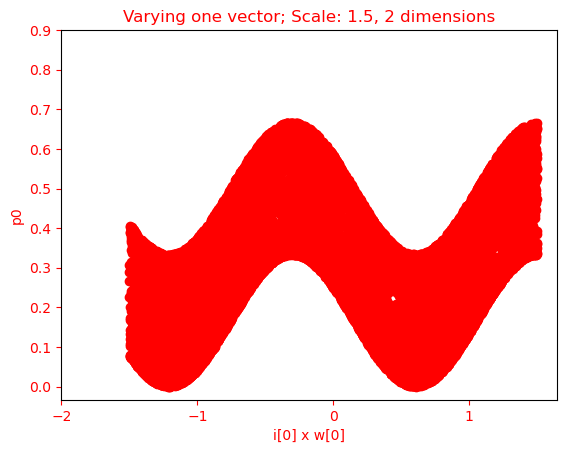

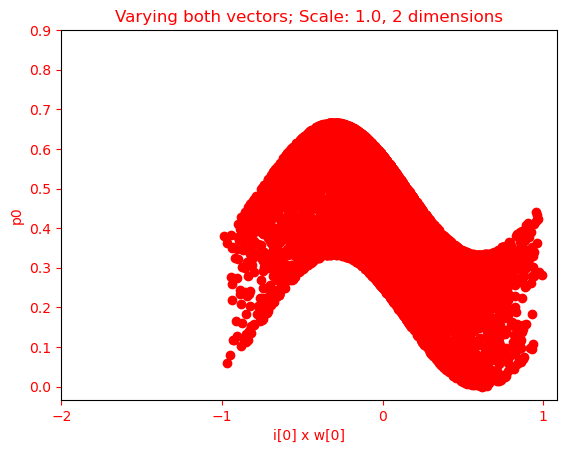

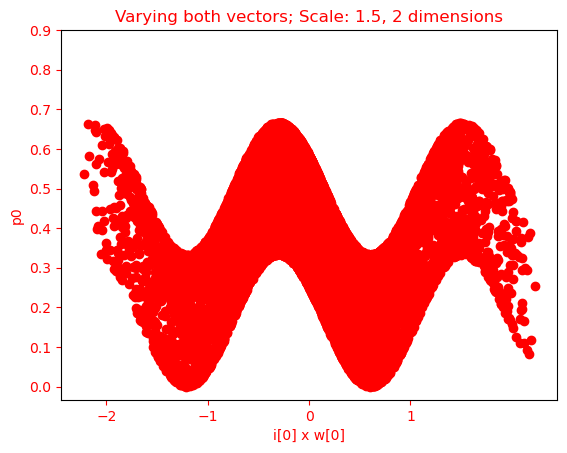

Wall time: 6.39 s


In [40]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, dimensions=2, varied_part=variation)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 2 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

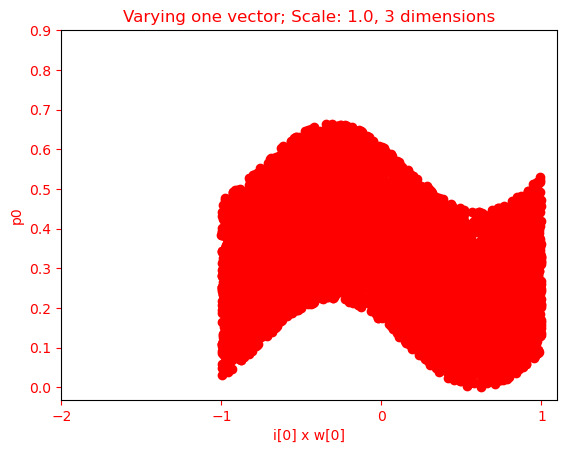

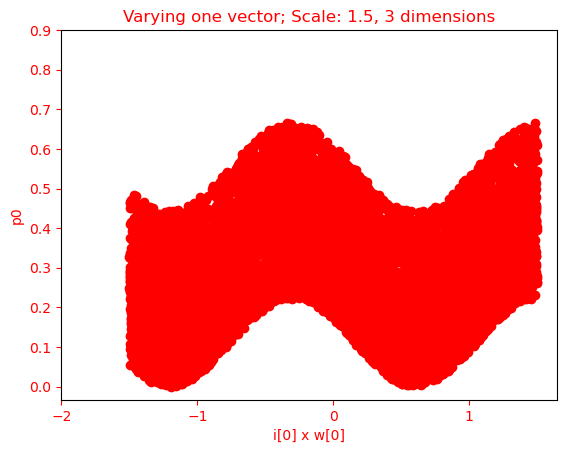

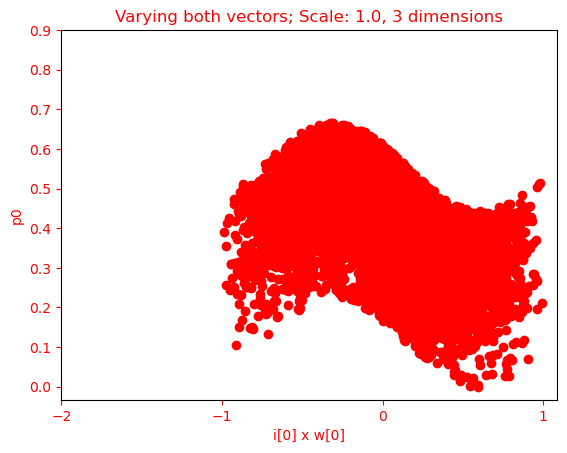

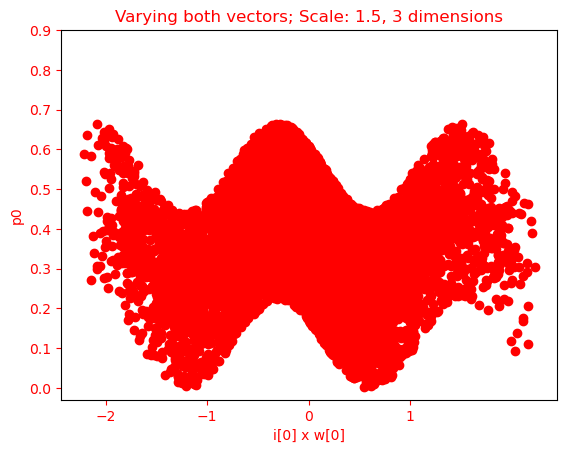

Wall time: 6.53 s


In [41]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, dimensions=3, varied_part=variation)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 3 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

In [42]:
from sympy import Matrix, exp, simplify, lambdify, Symbol
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct
from sympy.utilities.iterables import flatten
from toqito.channels import partial_trace

In [43]:
calc_fun_dict = dict()

def calculated_fun(i_n, w_n):
    global calc_fun_dict
    N = len(i_n)
    if not(N in calc_fun_dict):
        sigma_q_sympy = Matrix([
            [1, (1 - 1j)],
            [(1j + 1), -1]
        ])

        sigma_e_sympy = Matrix(np.zeros((N, N)))
        for i in range(N):
            sigma_e_sympy[i, i] = Symbol(chr(ord('a') + i)) * Symbol(chr(ord('A') + i))

        sigma_e_sigma_q = 1j*TensorProduct(sigma_q_sympy, sigma_e_sympy)
            
        # TensorProduct = Kroenecker product: https://docs.sympy.org/latest/modules/physics/quantum/tensorproduct.html
        # exp = matrix exponential https://stackoverflow.com/questions/47240208/sympy-symbolic-matrix-exponential
        u_operator_sympy = Matrix(sigma_e_sigma_q).exp()
            
        p_cog = Matrix([
            [1/2,1/2],
            [1/2,1/2]
            ])
            
        # rho_env = 1/sqrt(n) |00...0> + 1/sqrt(n) |00...1> + ... + 1/sqrt(n) |11...1>
        # Thus rho_env = rho_env x rho_env*, which will end up in a 1/sqrt(N) * 1/sqrt(N) * Matrix(N,N)
        p_env = Matrix(np.ones((N,N)) * (1/N))
                
        quantum_operation_sympy = u_operator_sympy * TensorProduct(p_cog, p_env) * Dagger(u_operator_sympy)

        args = [Symbol(chr(ord('a') + i)) for i in range(N)] + [Symbol(chr(ord('A') + i)) for i in range(N)]
        calc_fun_dict[N] =  lambdify(flatten(args), quantum_operation_sympy) 
    
    args = np.append(i_n, w_n)
    rho = calc_fun_dict[N](*args)
    part_trace = partial_trace(rho, sys = 2, dim=[2, N])
    p_cog_00 = part_trace[0,0]
    p_cog_11 = part_trace[1,1]

    if (p_cog_00 >= p_cog_11):
        z = 0
    else:
        z = 1
    return z, p_cog_11

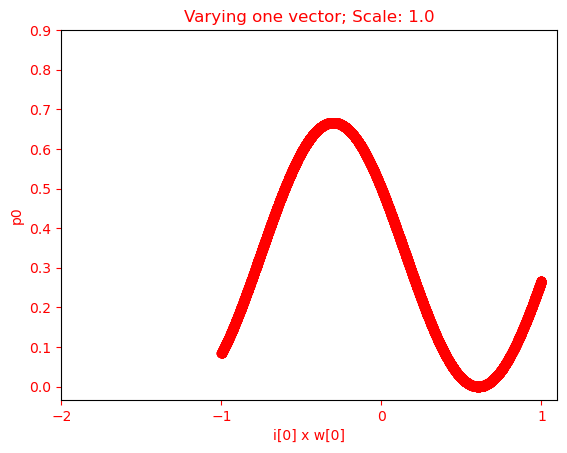

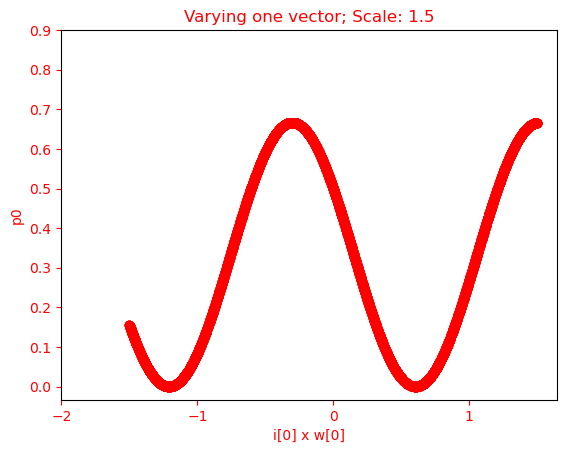

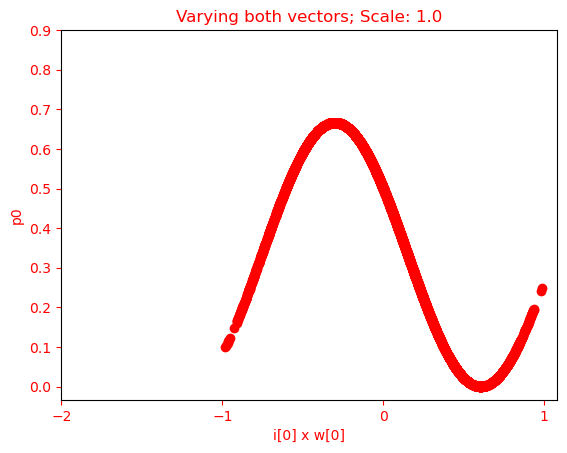

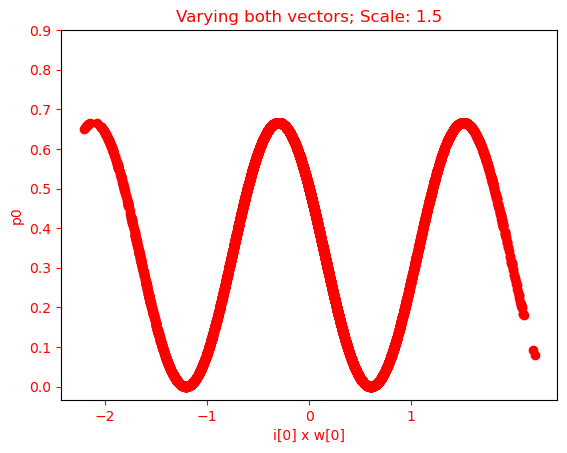

Wall time: 9.25 s


In [44]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=calculated_fun)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)

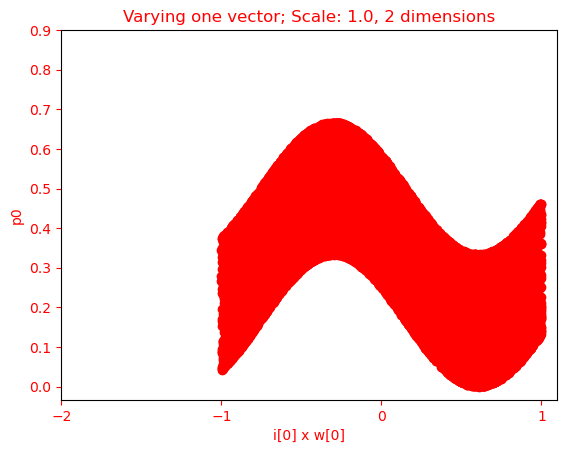

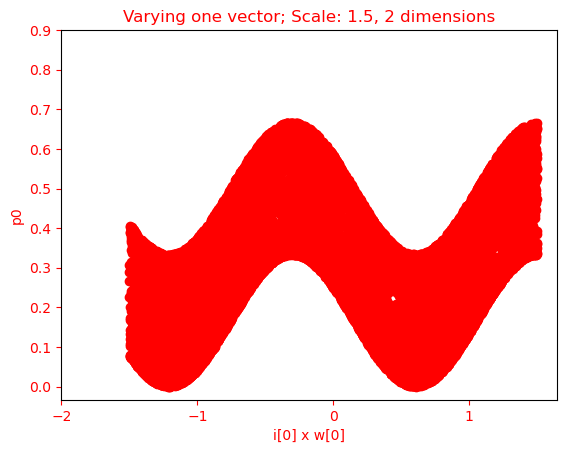

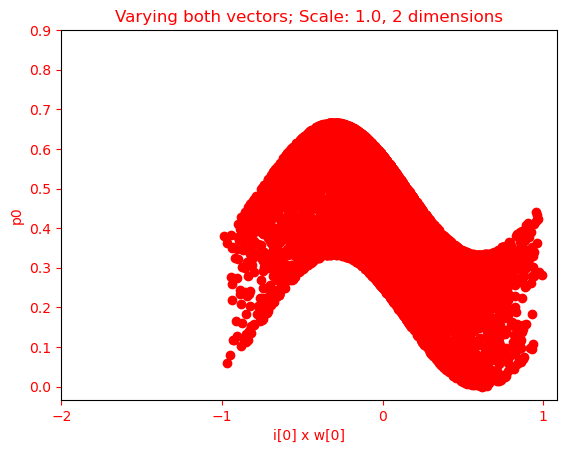

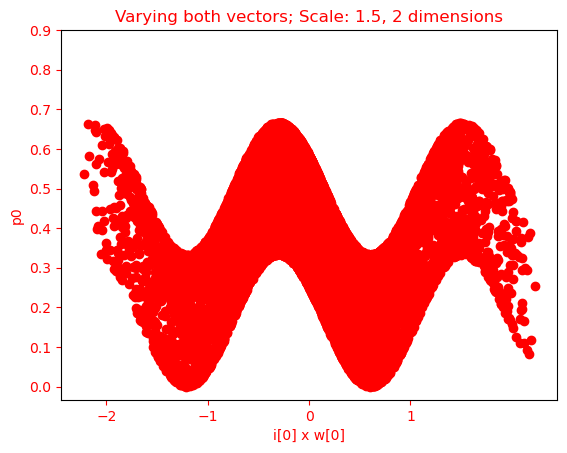

Wall time: 20.2 s


In [45]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, dimensions=2, output_func=calculated_fun)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 2 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

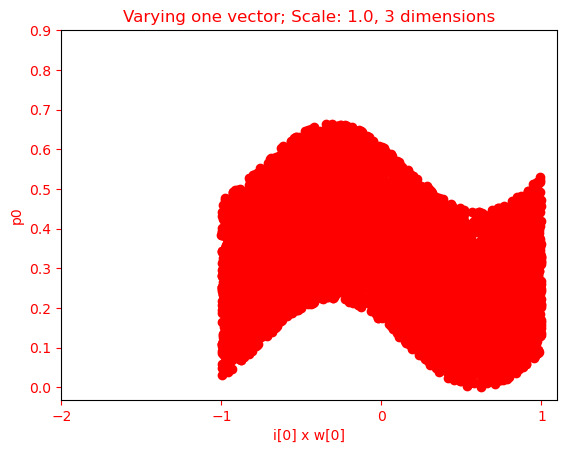

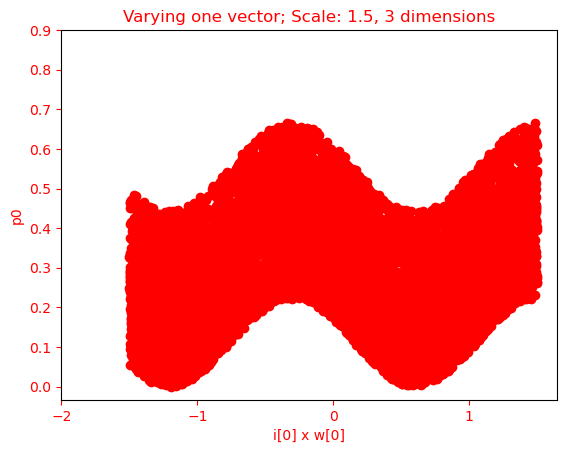

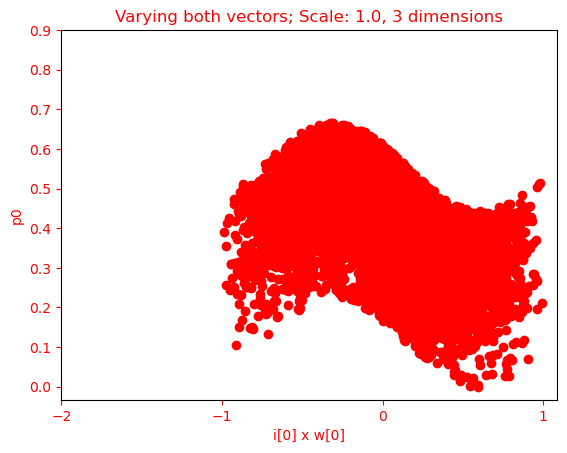

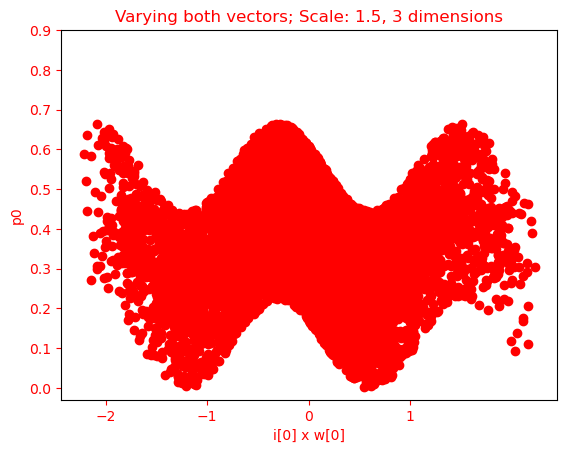

Wall time: 39.5 s


In [46]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, dimensions=3, output_func=calculated_fun)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 3 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

In [47]:
def classical_neuron_output_func(i_n, w_n):
    x = np.dot(i_n, w_n)
    activation = 1 / (1 + np.exp(-x))
    return np.round(activation), activation

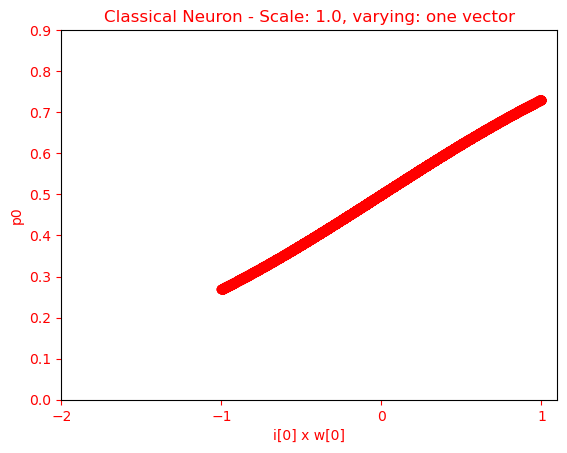

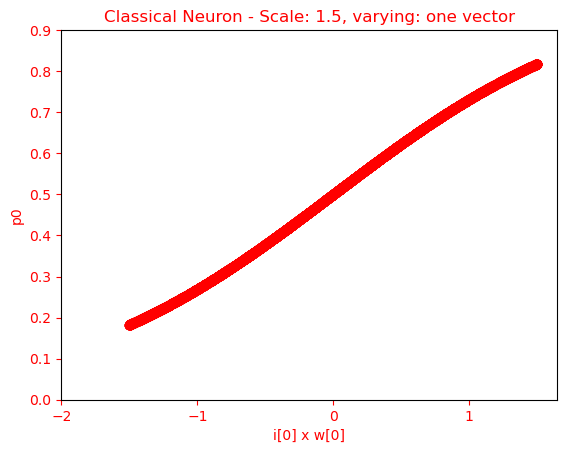

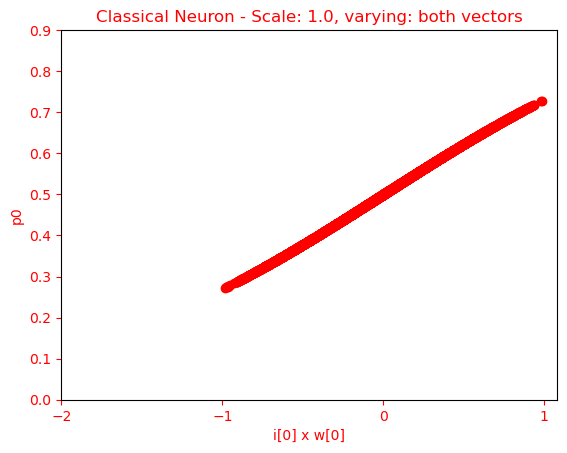

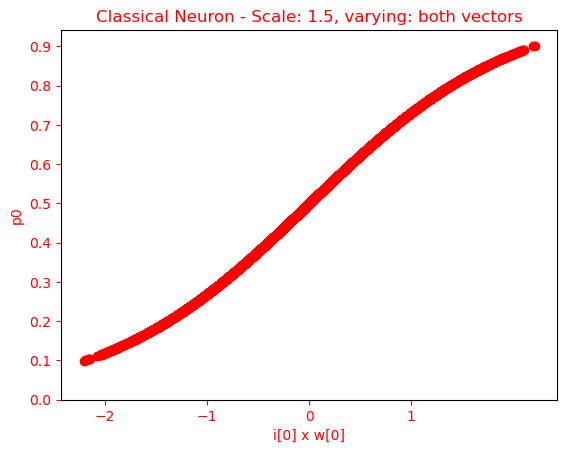

Wall time: 845 ms


In [48]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=classical_neuron_output_func)
        plt.title("Classical Neuron - " + "Scale: " + str(n) + ", varying: " + vary, color = "red")
        plot_graph(list_of_x, list_of_y)

In [49]:
calculated_fun_split_fun_dict = dict()

def calculated_fun_split(i_n, w_n):
    global calc_fun_dict
    N = len(i_n)
    if not(N in calc_fun_dict):
        sigma_q_sympy = Matrix([
            [1, (1 - 1j)],
            [(1j + 1), -1]
        ])

        sigma_e_sympy = Matrix(np.zeros((N, N)))
        for i in range(N):
            sigma_e_sympy[i, i] = Symbol(chr(ord('a') + i))

        sigma_e_sigma_q = 1j*TensorProduct(sigma_q_sympy, sigma_e_sympy)
            
        # TensorProduct = Kroenecker product: https://docs.sympy.org/latest/modules/physics/quantum/tensorproduct.html
        # exp = matrix exponential https://stackoverflow.com/questions/47240208/sympy-symbolic-matrix-exponential
        u_operator_sympy = Matrix(sigma_e_sigma_q).exp()
            
        p_cog = Matrix([
            [1/2,1/2],
            [1/2,1/2]
            ])
            
        # Now we have the weights in the amplitudes
        env_psi = [(1/np.sqrt(N)) * Symbol(chr(ord('A') + i) for i in range(N))]
        p_env = Matrix(env_psi) * Matrix(env_psi).exp()
                
        quantum_operation_sympy = u_operator_sympy * TensorProduct(p_cog, p_env) * Dagger(u_operator_sympy)

        args = [Symbol(chr(ord('a') + i)) for i in range(N)] + [Symbol(chr(ord('A') + i)) for i in range(N)]
        calc_fun_dict[N] =  lambdify(flatten(args), quantum_operation_sympy) 
    
    args = np.append(i_n, w_n)
    rho = calc_fun_dict[N](*args)
    part_trace = partial_trace(rho, sys = 2, dim=[2, N])
    p_cog_00 = part_trace[0,0]
    p_cog_11 = part_trace[1,1]

    if (p_cog_00 >= p_cog_11):
        z = 0
    else:
        z = 1
    return z, p_cog_11

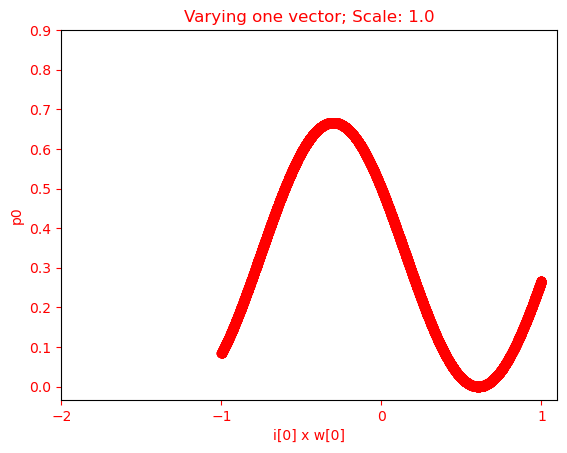

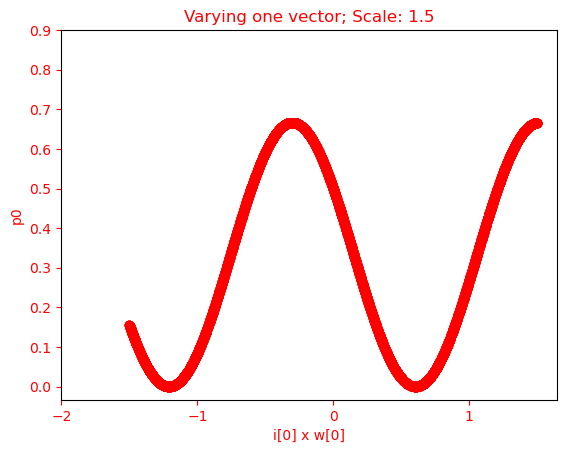

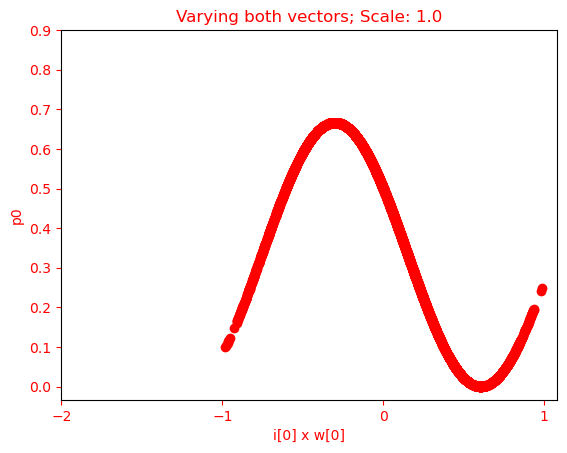

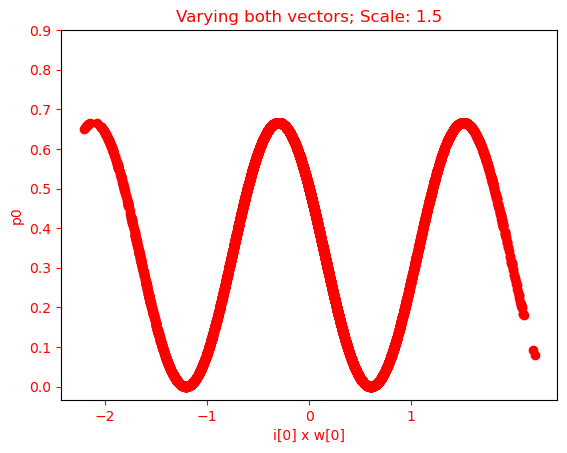

Wall time: 9.03 s


In [50]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=calculated_fun_split)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)

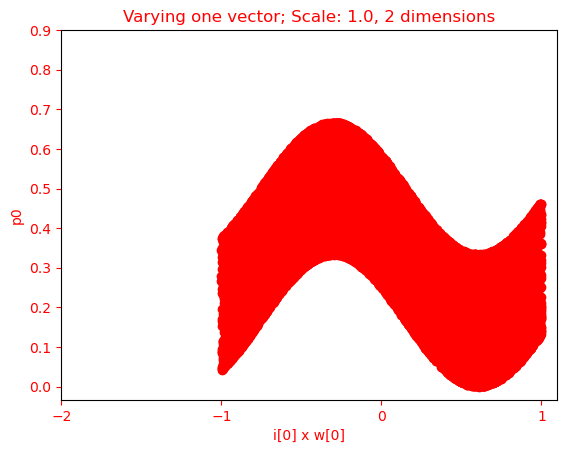

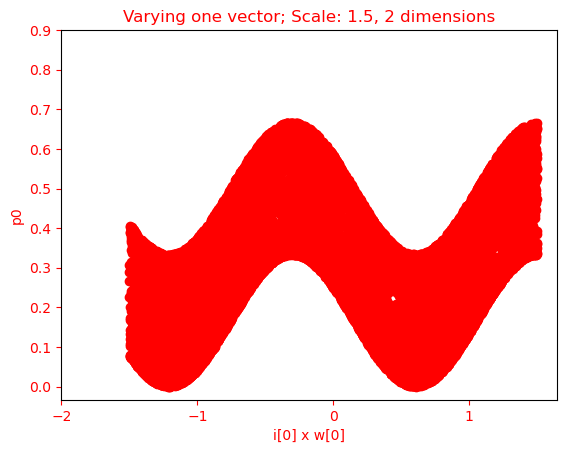

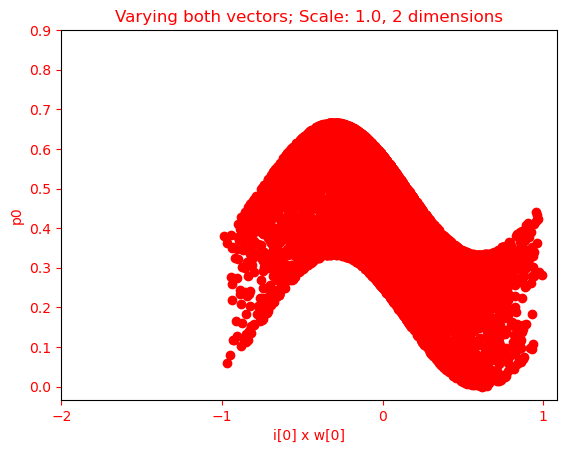

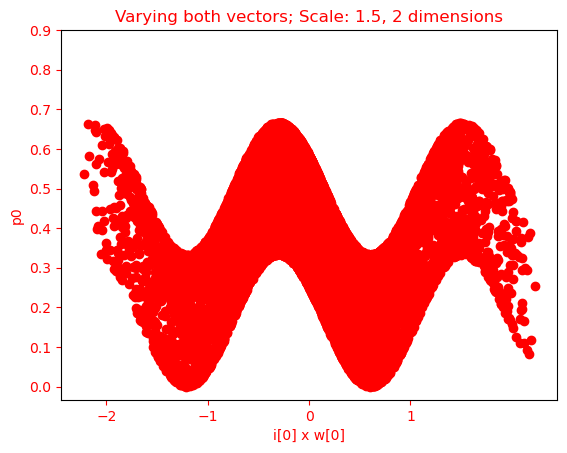

Wall time: 19.8 s


In [51]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, dimensions=2, output_func=calculated_fun_split)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 2 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)

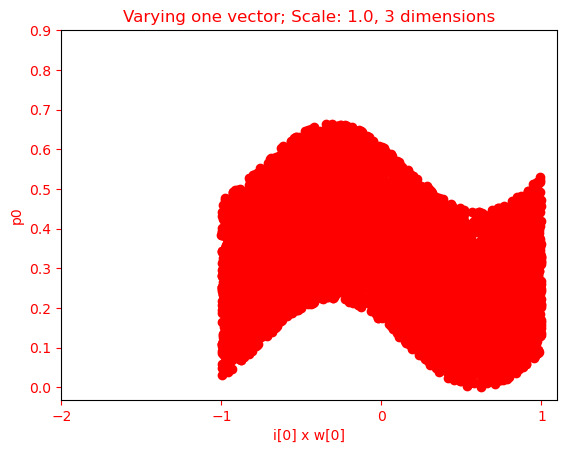

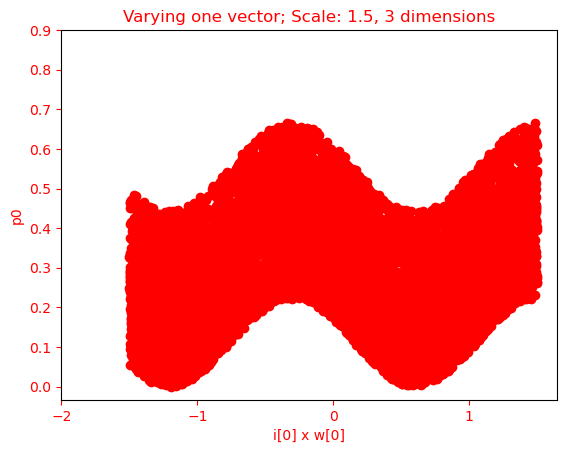

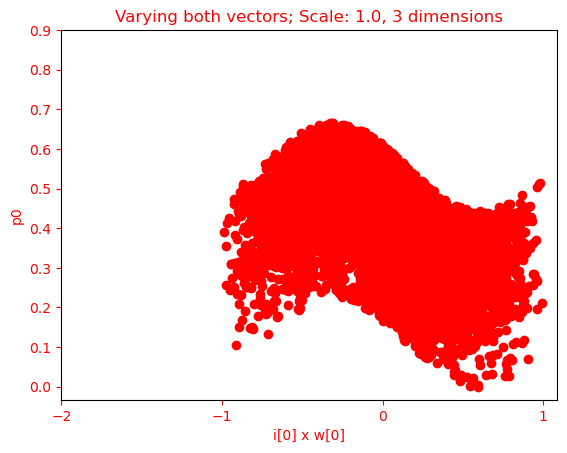

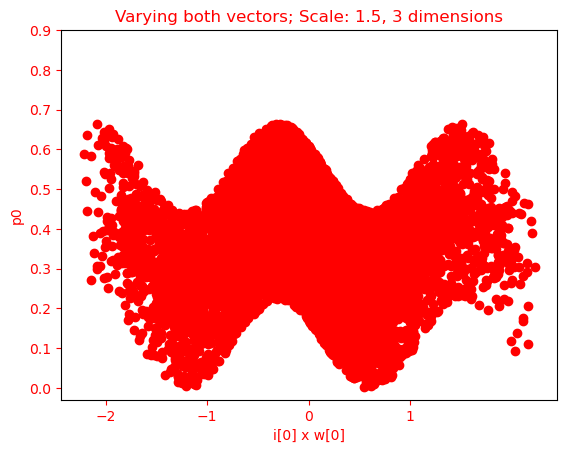

Wall time: 37 s


In [52]:
%%time
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(MIN_RANGE, MAX_RANGE, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, dimensions=3, output_func=calculated_fun_split)
        plt.title("Varying " + vary + "; Scale: " + str(n) + ", 3 dimensions", color = "red")
        plot_graph(list_of_x, list_of_y)